# Softmax exercise

We will implement a softmax classifier that is trained on the CIFAR10 dataset. The output is a model that is able to classify the input image into the 10 different classes of the CIFAR10 dataset.

Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- use a validation set to **tune the learning rate** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from random import shuffle

from six.moves import cPickle as pickle
import numpy as np
import os
from imageio import imread
import platform
from torchvision import datasets


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Load the dataset

In [4]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  datasets.CIFAR10(
        root="data/", train=True,
        download=True, transform=None,
    )
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  return Xtr, Ytr


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar-10-batches-py'
    X_train, y_train = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]

    # Normalize the data: subtract the mean image and divide by variance
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    X_train = np.divide(np.subtract( X_train/255 , mean[np.newaxis,np.newaxis,:]), std[np.newaxis,np.newaxis,:])
    X_val = np.divide(np.subtract( X_val/255 , mean[np.newaxis,np.newaxis,:]), std[np.newaxis,np.newaxis,:])

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])

    return X_train, y_train, X_val, y_val


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

100%|██████████| 170498071/170498071 [00:02<00:00, 78326143.10it/s]


Extracting data/cifar-10-python.tar.gz to data/
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)


## Softmax Classifier

Here, you implement **softmax_loss_vectorized**. This function just returns the loss and gradient after applying the softmax function.


In [5]:
def softmax_loss_vectorized(W, X, y):
    """
    Softmax loss function, vectorized version.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability.                         #

    #scores
    scores = X.dot(W)  #score is what I obtain from W*X, I want to maximize the correct one
        # dimension (N,C)

    #avoid numerical instability
    scores -= np.max(scores, axis=1, keepdims=True)
        # dimension (N,C)
        # By subtracting the maximum values from the scores, we ensure that the largest score
        # is zero, which prevents the exponential function from overflowing.

    #softmax scores
    softmax_scores = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
        # axis = 1 means that I want to sum over the columns, so I obtain a row vector with the sum of the elements of each row
        # dividing is made between vectors so elementwise
        # dimension (N,C)

    #loss: negative log likelihood: shape are (N,)
    N = X.shape[0]
    loss = -np.sum(np.log(softmax_scores[np.arange(N), y])) / N
        # softmax_scores[np.arange(N), y] is a vector of length N, where each element is the selected one from each row of the
            # softmax_scores array, corresponding to the correct class for each sample in the batch.
        # division by N to get the average loss over the batch
        # dimension pof loss is (1,), it is a float then


    #gradient --> see cell below for formulas
    softmax_scores[np.arange(N), y] -= 1  #gradient w.r.t. softmax scores
    dW = X.T.dot(softmax_scores) / N  #gradient w.r.t. weights W


    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW

# Theory I wrote to implement these formulas
  ## Softmax Function
  The softmax function converts logits (also known as scores) into probabilities. For a given class \( j \) and a single input vector \( \mathbf{x} \), the softmax function is defined as:

  $$
  \text{softmax}(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{C} e^{z_k}}
  $$

  where $ \mathbf{z} = W^T \mathbf{x} $ is the vector of logits for all classes and C is the total number of classes.

  ## Softmax Loss (Cross-Entropy Loss)
  For a single example, the cross-entropy loss for the correct class y is given by:

  $$ L = -\log(\text{softmax}(z)_y) = -\log\left(\frac{e^{z_y}}{\sum_{k=1}^{C} e^{z_k}}\right)  $$

  ## Derivative of the Softmax Function
  To compute the gradient of the loss with respect to the logits $ \mathbf{z} $, we first need the derivative of the softmax function. Let's denote the softmax probabilities as $ p_j = \text{softmax}(z)_j $. The derivative of $ p_j $ with respect to z_i is:

  $$ \frac{\partial p_j}{\partial z_i} = \begin{cases} p_j (1 - p_i) & \text{if } i = j, \\ -p_i p_j & \text{otherwise}. \end{cases} $$

  ## Derivative of the Cross-Entropy Loss
  The gradient of the loss \( L \) with respect to the logits \( \mathbf{z} \) for a single example is:

  $$ \frac{\partial L}{\partial z_i} = \begin{cases} p_i - 1 & \text{if } i = y, \\ p_i & \text{otherwise}. \end{cases} $$

  This formula comes from applying the chain rule to the loss function, considering how the loss changes as the logits change.

  ## Gradient with Respect to Weights
  Finally, the gradient of the loss with respect to the weights  W  is found by applying the chain rule once more, considering how the logits \$\mathbf{z} = W^T \mathbf{x} $ depend on W :

  $$ \frac{\partial L}{\partial W} = \frac{\partial L}{\partial \mathbf{z}} \frac{\partial \mathbf{z}}{\partial W} $$

  Given $ \mathbf{z} = W^T \mathbf{x} $, we have $ \frac{\partial \mathbf{z}}{\partial W} = \mathbf{x} $ (since $ \mathbf{z} $ is linear in $ W $). Thus, for each class  j

  $$ \frac{\partial L}{\partial W_{:,j}} = (p_j - 1(y=j)) \mathbf{x} $$

  where $ 1(y=j) $ is the indicator function, equal to 1 if $ y = j $ and 0 otherwise.


## This is the Softmax Linear Classifier.
### Implement SGD in the train function.
### Write the predict function to evaluate the performance on both the training and validation set
### Do not touch the loss function. You already defined it above.

In [6]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
            training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
            means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)
            indices = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[indices,:]
            y_batch = y[indices]

            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch)
            loss_history.append(loss)

            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            self.W -= learning_rate * grad
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
        training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
        array of length N, and each element is an integer giving the predicted
        class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        y_pred = np.argmax(X.dot(self.W), axis=1)

        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, X_batch, y_batch):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
            data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        raise NotImplementedError("Subclasses must override loss method")




Finally, the softmax class is inherited from LinearClassifier and uses the softmax_loss_vectorized function as its loss:

In [7]:
class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch):
        return softmax_loss_vectorized(self.W, X_batch, y_batch)

In [8]:
W = np.random.randn(3073, 10) * 0.0001
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_val, y_val)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

vectorized loss: 2.303676e+00 computed in 0.048428s


In [15]:
# Use the validation set to tune hyperparameters (learning rate).
# You should experiment with different ranges for the learning
# rates; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [4e-6, 5e-3]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning.                                  #
# Save the best trained softmax classifer in best_softmax.                     #
################################################################################
best_softmax = Softmax()

for lr in np.linspace(learning_rates[0], learning_rates[1], num=20):
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=lr, num_iters=1500, verbose=False)
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred) #mean of the boolean array 1 is if the prediction is correct
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[lr] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_softmax = softmax
    print('lr %e train accuracy: %f val accuracy: %f' % (lr, train_accuracy, val_accuracy))

print(" \n")
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr in sorted(results):
    train_accuracy, val_accuracy = results[lr]
    print('lr %e train accuracy: %f val accuracy: %f' % (
                lr, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 4.000000e-06 train accuracy: 0.244694 val accuracy: 0.248000
lr 2.669474e-04 train accuracy: 0.385143 val accuracy: 0.390000
lr 5.298947e-04 train accuracy: 0.395204 val accuracy: 0.388000
lr 7.928421e-04 train accuracy: 0.405776 val accuracy: 0.399000
lr 1.055789e-03 train accuracy: 0.409327 val accuracy: 0.394000
lr 1.318737e-03 train accuracy: 0.410918 val accuracy: 0.402000
lr 1.581684e-03 train accuracy: 0.415510 val accuracy: 0.406000
lr 1.844632e-03 train accuracy: 0.416000 val accuracy: 0.402000
lr 2.107579e-03 train accuracy: 0.417388 val accuracy: 0.406000
lr 2.370526e-03 train accuracy: 0.421061 val accuracy: 0.412000
lr 2.633474e-03 train accuracy: 0.416327 val accuracy: 0.398000
lr 2.896421e-03 train accuracy: 0.417429 val accuracy: 0.391000
lr 3.159368e-03 train accuracy: 0.421735 val accuracy: 0.416000
lr 3.422316e-03 train accuracy: 0.415286 val accuracy: 0.408000
lr 3.685263e-03 train accuracy: 0.421673 val accuracy: 0.409000
lr 3.948211e-03 train accuracy: 0.421143

In [16]:
# Evaluate the best softmax on val set
y_val_pred = best_softmax.predict(X_val)
val_accuracy = np.mean(y_val == y_val_pred)
print('softmax on raw pixels final test set accuracy: %f' % (val_accuracy, ))

softmax on raw pixels final test set accuracy: 0.416000


Save the best_softmax weights using pickle:

In [17]:
with open('drive/MyDrive/Colab Notebooks/softmax_weights.pkl', 'wb') as f:
    pickle.dump(best_softmax.W, f)


Load the best_softmax weights using pickle:

In [18]:
with open('drive/MyDrive/Colab Notebooks/softmax_weights.pkl', 'rb') as f:
    W = pickle.load(f)
new_softmax = Softmax()
new_softmax.W = W.copy()

Below is the code to visualize the weights learned for different classes. Try to notice the interesting patterns.

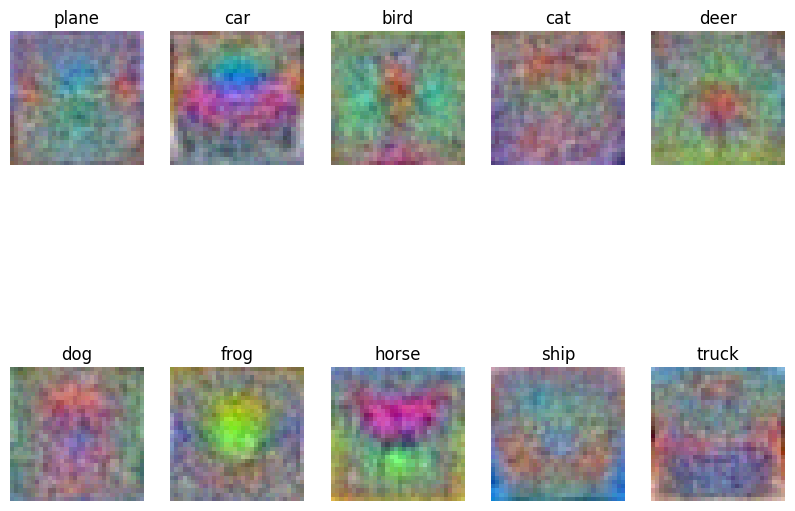

In [19]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])